In [3]:
print('Starting set-up. Importing ...\n')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(f'The imported  Tensorflow version is {tf.__version__} \n')

import os
import random

base_path = './raw-img/'
print(f'The base path to the inputs is : {base_path} \n')
        
print('Set-up completed, kernel ready.')

Starting set-up. Importing ...

The imported  Tensorflow version is 2.10.0 

The base path to the inputs is : ./raw-img/ 

Set-up completed, kernel ready.


## Let's print some random pictures

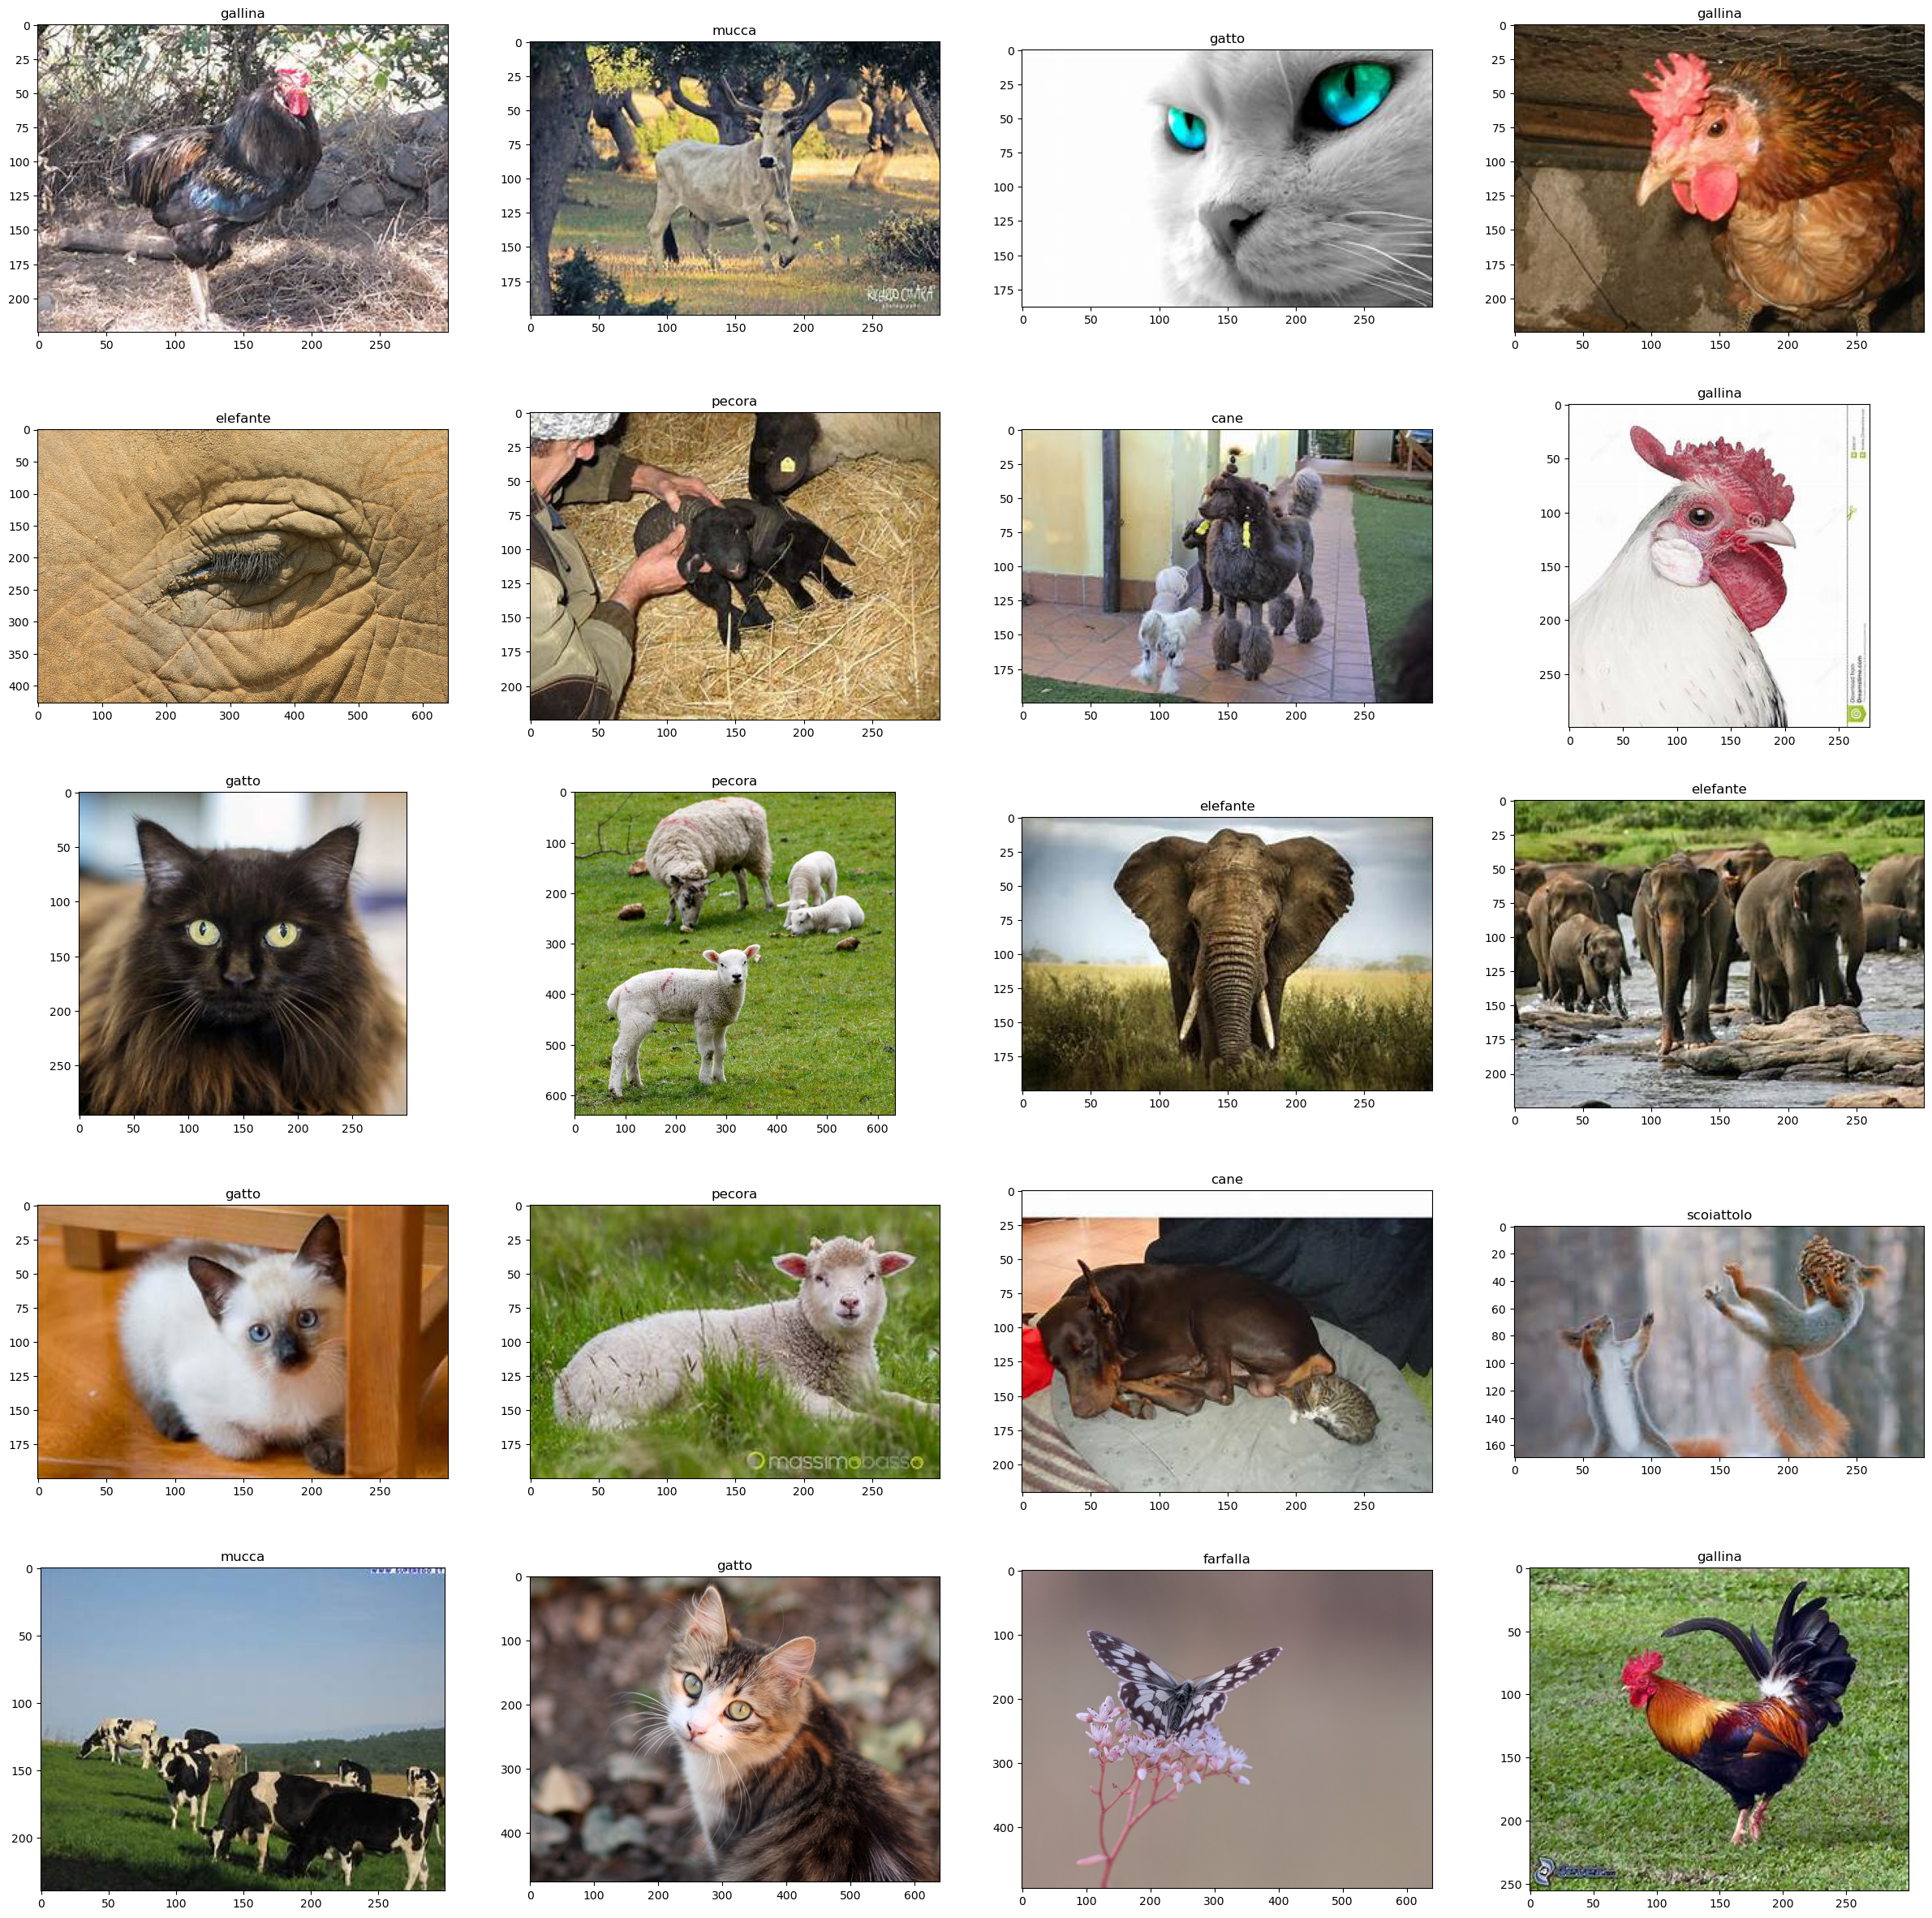

In [5]:
animals = ['cane', 'gallina', 'cavallo', 'gatto', 'mucca', 'farfalla',
           'scoiattolo', 'ragno', 'elefante', 'pecora']

random.seed(42)
columns = 4
rows = 5

fig=plt.figure(figsize=(30, 30))

for i in range(1, columns*rows +1):
    random_animal = random.choice(animals)
    random_picture = random.choice(os.listdir(os.path.join(base_path, random_animal)))
    img = plt.imread(os.path.join(base_path,random_animal,random_picture))
    f = fig.add_subplot(rows, columns, i)
    f.set_title(random_animal)
    plt.imshow(img)

## Create the data pipe

In [6]:
def datapipe(IMAGE_SHAPE, data_augmentation=False):
    if data_augmentation:
        image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                     rotation_range=10,
                                                                     height_shift_range=0.1,
                                                                     width_shift_range=0.1,
                                                                     horizontal_flip=True,
                                                                     zoom_range=0.1,
                                                                     validation_split=0.1)
    else:
        image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                          validation_split=0.1)
    
    training_data = image_generator.flow_from_directory(base_path, 
                                                        
                                                        target_size=IMAGE_SHAPE, 
                                                        subset='training', 
                                                        batch_size=32, 
                                                        class_mode='categorical', 
                                                        shuffle=True)
    validation_data = image_generator.flow_from_directory(base_path, 
                                                          target_size=IMAGE_SHAPE, 
                                                          subset='validation', 
                                                          batch_size=32, 
                                                          class_mode='categorical')
    
    for image_batch, label_batch in training_data:
        print('Training data ... ')
        print("Image batch shape: ", image_batch.shape)
        print("Label batch shape: ", label_batch.shape)
        break
        
    for image_batch, label_batch in validation_data:
        print('Validation data ... ')
        print("Image batch shape: ", image_batch.shape)
        print("Label batch shape: ", label_batch.shape)
        break
        
    return training_data, validation_data
training_data, validation_data = datapipe((256,256),data_augmentation=True)    

Found 23565 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Training data ... 
Image batch shape:  (32, 256, 256, 3)
Label batch shape:  (32, 10)
Validation data ... 
Image batch shape:  (32, 256, 256, 3)
Label batch shape:  (32, 10)


In [7]:
def model_from_scratch():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), input_shape=(256,256,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.summary()
    return model

def model_pretrained_VGG():
    bottom = tf.keras.applications.VGG16(weights='imagenet',include_top=False, input_shape=(256,256,3))
    bottom.trainable = False
    model = tf.keras.Sequential([
        bottom,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax'),
    ])
    model.summary()
    return model

In [12]:
model = model_from_scratch()

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer = tf.keras.optimizers.Adam(lr=1e-3),
             metrics = ['accuracy'])

steps_per_epoch = 23565/64 #find none hardcoded values




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 64)      

In [13]:
#with tf.device('/GPU:0'):
with tf.device()
h = model.fit_generator(training_data, 
                        validation_data=validation_data,
                        steps_per_epoch=steps_per_epoch,
                        epochs = 2)

C:\Users\AlessandroKuz\AppData\Local\Temp\ipykernel_18496\3399850131.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(training_data,


Epoch 1/2
368/368 [==============================] - 348s 944ms/step - loss: 2.0141 - accuracy: 0.2810 - val_loss: 1.8849 - val_accuracy: 0.3405
Epoch 2/2
368/368 [==============================] - 351s 952ms/step - loss: 1.6568 - accuracy: 0.4267 - val_loss: 1.4965 - val_accuracy: 0.4847


In [ ]:
print(h.history['val_loss'])